In [1]:
%cd /work/adapting-CLIP-VGPs/
import clip

GPU = 7
model, _ = clip.load('ViT-L/14', device=GPU)

/work/adapting-CLIP-VGPs


In [2]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def text_cos_sim(phrases):
    phrases_tensor = clip.tokenize(phrases).to(GPU)
    text_ft = model.encode_text(phrases_tensor)
    return cosine_similarity(text_ft.cpu().detach())[0,1]

def contains_non_ascii(s):
    return any(ord(c) > 127 for c in s)
def replace_non_ascii(s):
    return ''.join(c if ord(c) < 128 else '?' for c in s)
def get_heatmap_path(dataroot, img_path, phrase):
    heatmap_path = f'{dataroot}{img_path}/{phrase}.npz'
    heatmap_path = replace_non_ascii(heatmap_path) if contains_non_ascii(heatmap_path) else heatmap_path
    return heatmap_path

def load_heatmap(path):
    data = np.load(path, allow_pickle=True)
    heatmap = np.array([data[f'arr_{i}'] for i in range(len(data))], dtype=np.float32)
    # heatmap_tensor = torch.from_numpy(heatmap).unsqueeze(0).unsqueeze(0).to(gpu)
    return heatmap
def hm_cos_sim(dataroot, img_path, phrases):
    h1_path = get_heatmap_path(dataroot, img_path, phrases[0])
    h2_path = get_heatmap_path(dataroot, img_path, phrases[1])
    h1 = load_heatmap(h1_path)
    h2 = load_heatmap(h2_path)
    return cosine_similarity(h1.reshape(1, -1), h2.reshape(1, -1))[0, 0] 

In [4]:
from utils.vgp_data import FlickrVGPsDataset

test_dataset = FlickrVGPsDataset(data_type='test')
val_dataset = FlickrVGPsDataset(data_type='val')

In [ ]:
from tqdm import tqdm
import csv

DATAROOT = '/work/adapting-CLIP-VGPs/data/flickr/heatmaps/test/'
thres = 0.7
data_cols = ['img_idx', 'phrases', 'text_sim', 'heatmap_sim', 'avgsim', 'pred', 'ytrue']

filename = '/work/adapting-CLIP-VGPs/text_hm.csv'
with open(filename, mode='a', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(data_cols)

    for data in tqdm(test_dataset):
        img_idx = data['image_idx']
        phrases = data['phrases']
        ytrue = data['label']

        text_sim = text_cos_sim(phrases)
        hm_sim = hm_cos_sim(DATAROOT, img_idx, phrases)
        score = (text_sim+hm_sim)/2
        pred = score > thres
        
        writer.writerow([img_idx, phrases, text_sim, hm_sim, score, pred, ytrue])

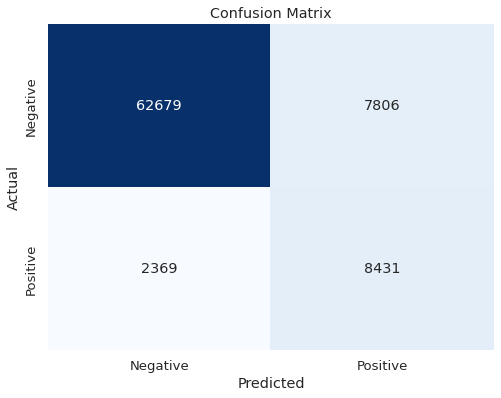

Accuracy: 0.8748231531032786
Precision: 0.5192461661637002
Recall: 0.7806481481481482
F1 Score: 0.6236638680326959


In [12]:
import pandas as pd

val_results = pd.read_csv('/work/adapting-CLIP-VGPs/text_hm_test.csv')
pred = val_results['pred']
gt = val_results['ytrue']

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Replace actual_labels and predicted_labels with your own data
cm = confusion_matrix(gt, pred)

# Define class labels
class_labels = ['Negative', 'Positive']

# Create a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust font size
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels, cbar=False)

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

from sklearn.metrics import precision_score, recall_score, f1_score

# Calculate precision
precision = precision_score(gt, pred)

# Calculate recall
recall = recall_score(gt, pred)

# Calculate F1 score
f1 = f1_score(gt, pred)

# Calculate accuracy
acc = sum(x==y for x,y in zip(gt,pred))/len(gt)

print(f'Accuracy: {acc}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

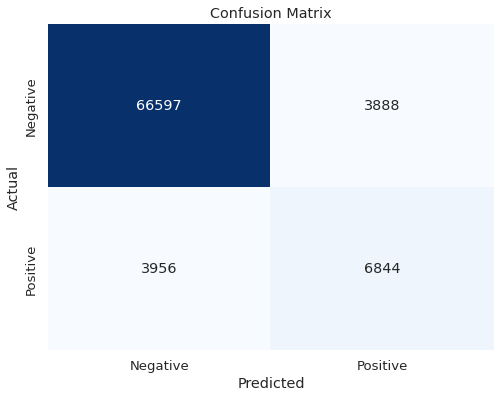

Accuracy: 0.9035000307559821
Precision: 0.6377189713007827
Recall: 0.6337037037037037
F1 Score: 0.6357049972134498


In [14]:
pred = val_results['heatmap_sim'] > 0.74

# Replace actual_labels and predicted_labels with your own data
cm = confusion_matrix(gt, pred)

# Define class labels
class_labels = ['Negative', 'Positive']

# Create a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust font size
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels, cbar=False)

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

from sklearn.metrics import precision_score, recall_score, f1_score

# Calculate precision
precision = precision_score(gt, pred)

# Calculate recall
recall = recall_score(gt, pred)

# Calculate F1 score
f1 = f1_score(gt, pred)

# Calculate accuracy
acc = sum(x==y for x,y in zip(gt,pred))/len(gt)

print(f'Accuracy: {acc}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

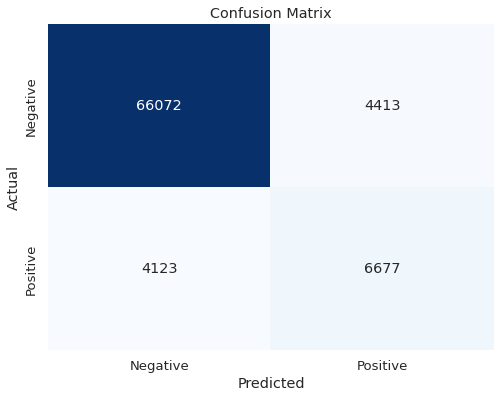

Accuracy: 0.8949867749277235
Precision: 0.6020739404869252
Recall: 0.6182407407407408
F1 Score: 0.6100502512562814


In [13]:
pred = val_results['text_sim'] > 0.809

# Replace actual_labels and predicted_labels with your own data
cm = confusion_matrix(gt, pred)

# Define class labels
class_labels = ['Negative', 'Positive']

# Create a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust font size
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels, cbar=False)

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

from sklearn.metrics import precision_score, recall_score, f1_score

# Calculate precision
precision = precision_score(gt, pred)

# Calculate recall
recall = recall_score(gt, pred)

# Calculate F1 score
f1 = f1_score(gt, pred)

# Calculate accuracy
acc = sum(x==y for x,y in zip(gt,pred))/len(gt)

print(f'Accuracy: {acc}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

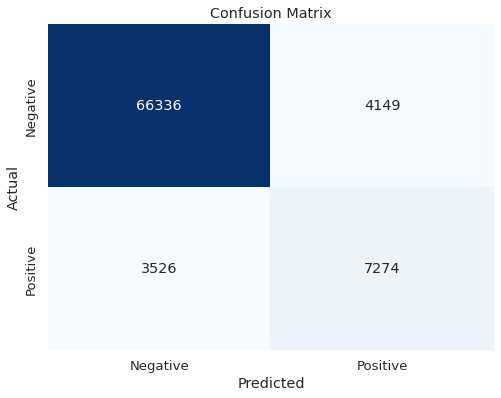

Accuracy: 0.9055791351417851
Precision: 0.6367854328985381
Recall: 0.6735185185185185
F1 Score: 0.6546370877019305


In [15]:
pred = val_results['avgsim'] > 0.753

# Replace actual_labels and predicted_labels with your own data
cm = confusion_matrix(gt, pred)

# Define class labels
class_labels = ['Negative', 'Positive']

# Create a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust font size
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels, cbar=False)

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

from sklearn.metrics import precision_score, recall_score, f1_score

# Calculate precision
precision = precision_score(gt, pred)

# Calculate recall
recall = recall_score(gt, pred)

# Calculate F1 score
f1 = f1_score(gt, pred)

# Calculate accuracy
acc = sum(x==y for x,y in zip(gt,pred))/len(gt)

print(f'Accuracy: {acc}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

In [4]:
import numpy as np

def find_best_f1(pred, gt):
    step = 0.001
    cur_best_f1 = 0
    cur_prec = 0
    cur_rec = 0
    cur_best_thres = 0.5
    for thres in np.arange(cur_best_thres, 1, step):
        new_pred = pred > thres
        f1 = f1_score(gt, new_pred)

        if f1 > cur_best_f1:
            cur_best_thres = thres
            cur_best_f1 = f1
            cur_prec = precision_score(gt, new_pred)
            cur_rec = recall_score(gt, new_pred)

    return cur_best_thres, cur_best_f1, cur_prec, cur_rec

In [5]:
find_best_f1(val_results['text_sim'],gt)

(0.8090000000000003, 0.5962550931648583, 0.588256549232159, 0.6044741483337974)

In [6]:
find_best_f1(val_results['heatmap_sim'],gt)

(0.7400000000000002, 0.6178102459774367, 0.6154767388300323, 0.620161514898357)

In [7]:
find_best_f1(val_results['avgsim'],gt)

(0.7530000000000002,
 0.6377514367816092,
 0.6176189233846422,
 0.6592406943284136)

## CNN

In [37]:
import torch
import torch.nn as nn

class TextHeatmapCNN(nn.Module):
    """
    A Convolutional Network for Text + Heatmap similarity.

    A customized version of Siamese NN.
    """

    def __init__(self):
        super(TextHeatmapCNN, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(1, 64, 10, padding=1),  # 64@216*216
            nn.ReLU(inplace=True),
            nn.MaxPool2d(4, stride=2),  # 64@107*107
            nn.Conv2d(64, 128, 7, padding=3),
            nn.ReLU(inplace=True),  # 128@104*104
            nn.MaxPool2d(4, stride=4),  # 128@26*26
        )
        self.liner = nn.Sequential(nn.Linear(128*26*26, 4096), nn.Sigmoid())
        self.textliner = nn.Sequential(nn.Linear(768, 4096, dtype=torch.float16), nn.Sigmoid())
        self.out = nn.Linear(4096*2, 1)

        # weight init
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_uniform_(m.weight)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)

    def sub_forward(self, x):
        """
        Forward pass the input image through 1 subnetwork.

        Args
        ----
        - x: a Variable of size (B, C, H, W). Contains either the first or
          second image pair across the input batch.

        Returns
        -------
        - out: a Variable of size (B, 4096). The hidden vector representation
          of the input vector x.
        """
        x = self.conv(x)
        x = x.view(x.size()[0], -1)
        x = self.liner(x)
        return x
    def sub_text_forward(self, x):
        """
        Forward pass the input image through 1 subnetwork.

        Args
        ----
        - x: a Variable of size (B, C, N). Contains either the first or
          second text pair across the input batch.

        Returns
        -------
        - out: a Variable of size (B, 4096). The hidden vector representation
          of the input vector x.
        """
        x = self.textliner(x)
        return x

    def forward(self, x1, x2, t1, t2):
        """
        Forward pass the input image pairs through both subtwins. An image
        pair is composed of a left tensor x1 and a right tensor x2.

        Concretely, we compute the component-wise L1 distance of the hidden
        representations generated by each subnetwork, and feed the difference
        to a final fc-layer followed by a sigmoid activation function to
        generate a similarity score in the range [0, 1] for both embeddings.

        Args
        ----
        - x1: a Variable of size (B, C, H, W). The left image pairs along the
          batch dimension.
        - x2: a Variable of size (B, C, H, W). The right image pairs along the
          batch dimension.

        Returns
        -------
        - probas: a Variable of size (B, 1). A probability scalar indicating
          whether the left and right input pairs, along the batch dimension,
          correspond to the same class. We expect the network to spit out
          values near 1 when they belong to the same class, and 0 otherwise.
        """
        # encode image pairs
        h1 = self.sub_forward(x1)
        h2 = self.sub_forward(x2)

        # merge with text encode
        t1 = self.sub_text_forward(t1).squeeze(1)
        t2 = self.sub_text_forward(t2).squeeze(1)
        h1 = torch.cat((h1, t1), 1)
        h2 = torch.cat((h2, t2), 1)

        # compute l1 distance
        diff = torch.abs(h1 - h2)

        # score the similarity between the 2 encodings
        scores = self.out(diff)

        # return scores (without sigmoid) and use bce_with_logit
        # for increased numerical stability
        return scores

In [38]:
%cd /work/adapting-CLIP-VGPs/
from torch.utils.data import DataLoader
from utils.heatmap_data import VGPsHeatmapsDataset
# from models.text_hm_cnn import TextHeatmapCNN

GPU = 7
train_dataset = VGPsHeatmapsDataset(split='train')
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=100,
    shuffle=False,
    num_workers=4,
    pin_memory=True
    # sampler=train_sampler
)
model = TextHeatmapCNN().to(GPU)
model.train()

/work/adapting-CLIP-VGPs


TextHeatmapCNN(
  (conv): Sequential(
    (0): Conv2d(1, 64, kernel_size=(10, 10), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=4, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  )
  (liner): Sequential(
    (0): Linear(in_features=86528, out_features=4096, bias=True)
    (1): Sigmoid()
  )
  (textliner): Sequential(
    (0): Linear(in_features=768, out_features=4096, bias=True)
    (1): Sigmoid()
  )
  (out): Linear(in_features=8192, out_features=1, bias=True)
)

In [39]:
import torch
import torch.nn as nn
import torch.optim as optim

# 損失関数の定義: pair wise loss
criterion = nn.BCEWithLogitsLoss()
# criterion = nn.CosineEmbeddingLoss()
# pairwise loss, contrastive los

# 最適化手法の定義
optimizer = optim.SGD(model.parameters(), lr=0.0005, momentum=0.9)


In [40]:
batch_iter = iter(train_loader)
batch = next(batch_iter)

In [41]:
gpu = GPU
phase = 'train'
image_paths = batch['img_idx']
left_text_ft = batch['left_text_emb']
right_text_ft = batch['right_text_emb']
left_heatmaps = batch['left_heatmap']
right_heatmaps = batch['right_heatmap']
labels = batch['label']

left_heatmaps = left_heatmaps.unsqueeze(1).to(gpu)
right_heatmaps = right_heatmaps.unsqueeze(1).to(gpu)
left_text_ft = left_text_ft.to(gpu)
right_text_ft = right_text_ft.to(gpu)
label_tensor = labels.float().unsqueeze(1).to(gpu)

epoch_loss = 0.0
epoch_TP = 0
epoch_FP = 0
epoch_FN = 0
epoch_TN = 0
processed = 0

In [42]:
print(left_heatmaps.shape)
print(right_heatmaps)


torch.Size([100, 1, 224, 224])
tensor([[[[0.0026, 0.0026, 0.0026,  ..., 0.0137, 0.0137, 0.0137],
          [0.0026, 0.0026, 0.0026,  ..., 0.0137, 0.0137, 0.0137],
          [0.0026, 0.0026, 0.0026,  ..., 0.0137, 0.0137, 0.0137],
          ...,
          [0.0018, 0.0018, 0.0018,  ..., 0.0043, 0.0043, 0.0043],
          [0.0018, 0.0018, 0.0018,  ..., 0.0043, 0.0043, 0.0043],
          [0.0018, 0.0018, 0.0018,  ..., 0.0043, 0.0043, 0.0043]]],


        [[[0.0000, 0.0000, 0.0000,  ..., 0.0162, 0.0162, 0.0162],
          [0.0000, 0.0000, 0.0000,  ..., 0.0162, 0.0162, 0.0162],
          [0.0000, 0.0000, 0.0000,  ..., 0.0162, 0.0162, 0.0162],
          ...,
          [0.0077, 0.0077, 0.0077,  ..., 0.0136, 0.0136, 0.0136],
          [0.0077, 0.0077, 0.0077,  ..., 0.0136, 0.0136, 0.0136],
          [0.0077, 0.0077, 0.0077,  ..., 0.0136, 0.0136, 0.0136]]],


        [[[0.0026, 0.0026, 0.0026,  ..., 0.0137, 0.0137, 0.0137],
          [0.0026, 0.0026, 0.0026,  ..., 0.0137, 0.0137, 0.0137],
       

In [44]:
print(right_text_ft.shape)

torch.Size([100, 1, 768])


In [45]:
optimizer.zero_grad()
with torch.set_grad_enabled(phase=='train'):
    outputs = model(left_heatmaps, right_heatmaps, left_text_ft, right_text_ft)
    loss = criterion(outputs, label_tensor)
    epoch_loss += loss.item() * len(image_paths)
    loss.backward()
    optimizer.step()
    
    probs = torch.sigmoid(outputs)
    preds = (probs > 0.5).float()

In [48]:
probs

tensor([[0.4850],
        [0.4689],
        [0.5049],
        [0.4748],
        [0.4808],
        [0.4874],
        [0.4846],
        [0.4839],
        [0.5242],
        [0.4958],
        [0.4830],
        [0.4703],
        [0.4846],
        [0.5242],
        [0.4830],
        [0.4807],
        [0.5111],
        [0.4912],
        [0.4969],
        [0.4817],
        [0.5120],
        [0.5149],
        [0.4969],
        [0.5120],
        [0.4893],
        [0.5154],
        [0.4959],
        [0.4903],
        [0.4901],
        [0.4903],
        [0.4505],
        [0.4888],
        [0.5065],
        [0.4819],
        [0.4762],
        [0.4702],
        [0.4594],
        [0.4664],
        [0.4938],
        [0.4589],
        [0.4817],
        [0.5013],
        [0.4616],
        [0.4763],
        [0.4877],
        [0.4785],
        [0.4841],
        [0.4825],
        [0.4854],
        [0.4469],
        [0.4948],
        [0.4788],
        [0.4681],
        [0.4608],
        [0.4754],
        [0

In [47]:
loss

tensor(0.6706, device='cuda:7', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)